In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
from astropy.io import fits
from astropy.wcs import WCS
import scipy.optimize as opt
from astropy.nddata import Cutout2D

In [6]:
## load fits files
hdu_head = fits.open("6Sigma1Floodfilllr14SigmaRFIBinaryMapPeakFlux-t0011.fits")
hdu_tail = fits.open("Neg6Sigma1Floodfilllr14SigmaRFIBinaryMapPeakFlux-t0011.fits")
hdu_beam = fits.open("beam5amin.fits")
streak = (hdu_head[0].data + hdu_tail[0].data)/hdu_beam[0].data
wcs = WCS(hdu_head[0].header, naxis=2)

x_array = []
y_array = []
## load data from csv file
with open("25544_extracted_mc_data_from_1160497672.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=",")
    for row in csv_reader:
        x,y,ra,dec,UTC,t,x_max,y_max,x_min,y_min,ra_max,ra_min,dec_max,dec_min= row

        if x == "x":
            continue
        
        else:
            x_array.append(float(x))
            y_array.append(float(y))


In [7]:
def twoD_Gaussian(data_tuple, amplitude, xo, yo, sigma):
    """
    model of a 2D circular beam
    Parameters
    ----------
    data_tupe   : the x and y mesh grid
    amplitude   : the amp at the peak
    xo          : the peak x location
    yo          : the peak y location
    sigma       : the variance of circular beam
    Returns
    -------
    returns a linear array of the beam
    """

    (x, y) = data_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (1**2)/(2*sigma**2) 
    b =  0
    c =  (1)/(2*sigma**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()



<IPython.core.display.Javascript object>


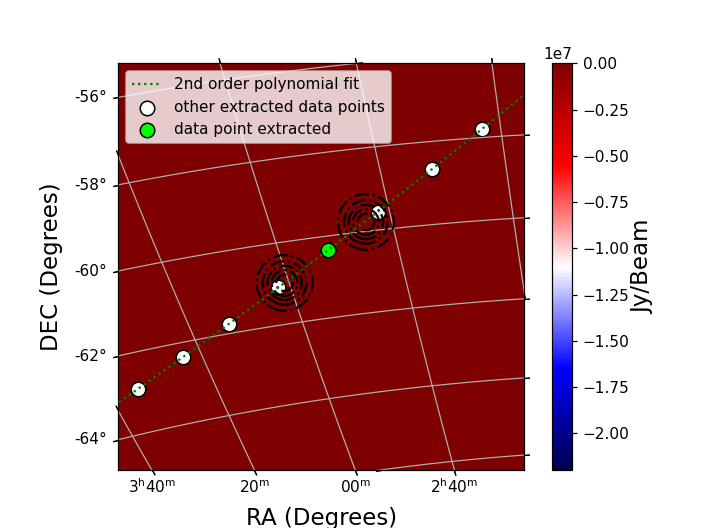

In [9]:
%matplotlib notebook
hfont = {'fontname':'Helvetica', 'size':15}
plt.subplot(111, projection=wcs)
plt.ylabel("DEC (Degrees)", **hfont)
plt.xlabel("RA (Degrees)", **hfont)
plt.imshow(streak, origin="lower", cmap=plt.cm.seismic,vmax=2000)
plt.colorbar().set_label("Jy/Beam", labelpad=+1, **hfont)

plt.scatter(x_array, y_array, marker="o", color="white", label="other extracted data points", edgecolors="black", s=90)
for x, y in zip(x_array, y_array):
    
    if  600<x < 610:
        plt.scatter(x, y, marker="o", color="lime", label="data point extracted", edgecolors="black", s= 90)
        continue
    
plt.xlim(555, 655)
plt.ylim(260, 360)

plt.grid()

## plot the head gaussian 
#row, col = np.where(streak == np.max(streak))
row, col = 305, 595
cutout = Cutout2D(streak, (col, row), (5,5))
temp = cutout.data/np.sum(cutout.data)
initial_guess = (temp[1,1], 1, 1, 2)
y = np.linspace(0, 4, 5)
x = np.linspace(0, 4, 5)
x, y = np.meshgrid(x, y) 
popt, pconv = opt.curve_fit(twoD_Gaussian, (x, y), temp.ravel(), p0=initial_guess)

x = np.linspace(0, 1399, 1400)
y = np.linspace(0, 1399, 1400)
x, y = np.meshgrid(x, y)
solX = 595+1
solY = 306+0
data_fit = twoD_Gaussian((x,y), popt[0], solX, solY, popt[3])
plt.contour(x, y, data_fit.reshape(1400, 1400), 5,alpha=1,colors="black",linestyles="dashdot")


solX = 615+1
solY = 321+0
data_fit = twoD_Gaussian((x,y), popt[0], solX, solY, popt[3])
plt.contour(x, y, data_fit.reshape(1400, 1400), 5,alpha=1,colors="black",linestyles="dashdot")


### line fit
z = np.polyfit(x_array, y_array, 2)
f = np.poly1d(z)

x_fit = np.linspace(0, 1399, 1400)
y_fit = f(x_fit)

plt.plot(x_fit, y_fit, label="2nd order polynomial fit",linestyle="dotted", color="green")

plt.legend()
plt.savefig("streakDATA_extraction.png", dpi=300)


In [5]:
np.nanmax(streak)

24831203.81200796

In [9]:
np.nanmin(streak)

-21980110.086744603